In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib import rcParams
import networkx as nx
%matplotlib inline
import scglue
import scrublet as scr

In [2]:
TAC_GEX = sc.read_10x_h5("/home/lugli/spuccio/Projects/CNR002/Lib_Multi_AFE-01/outs/filtered_feature_bc_matrix.h5")

/home/lugli/spuccio/anaconda3/envs/scglue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
TAC_GEX.var_names_make_unique()

In [4]:
SHAM_GEX =sc.read_10x_h5("/home/lugli/spuccio/Projects/CNR002/Lib_Multi_AFE-02/outs/filtered_feature_bc_matrix.h5")

/home/lugli/spuccio/anaconda3/envs/scglue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
SHAM_GEX.var_names_make_unique()

In [6]:
SHAM_GEX.obs['Condition'] = "SHAM"
TAC_GEX.obs['Condition'] = "TAC"

In [7]:
SHAM_GEX.obs['domain'] = "RNA"
TAC_GEX.obs['domain'] = "RNA"

In [8]:
SHAM_GEX.obs['OriginalBarcode'] = SHAM_GEX.obs.index
TAC_GEX.obs['OriginalBarcode'] = TAC_GEX.obs.index

In [9]:
Concatenato = TAC_GEX.concatenate([SHAM_GEX])

/home/lugli/spuccio/anaconda3/envs/scglue/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.1%
Elapsed time: 7.0 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

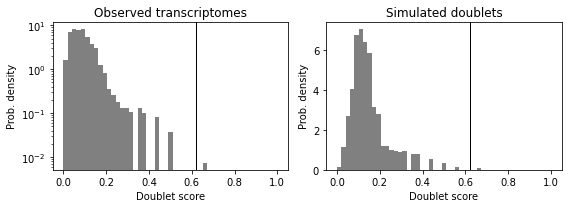

In [10]:
scrub = scr.Scrublet(Concatenato.X,expected_doublet_rate=0.06)
Concatenato.obs['doublet_scores'], Concatenato.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [11]:
Concatenato = Concatenato[Concatenato.obs['predicted_doublets'] == False,:]

/home/lugli/spuccio/anaconda3/envs/scglue/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


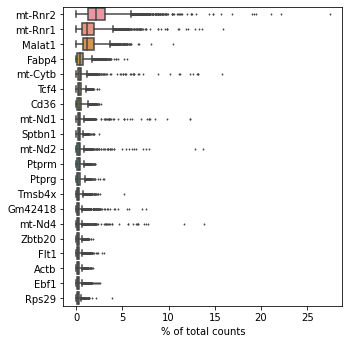

In [12]:
sc.pl.highest_expr_genes(Concatenato,n_top=20)

In [13]:
Concatenato.var['mt'] = Concatenato.var_names.str.startswith('mt-')

In [14]:
sc.pp.calculate_qc_metrics(Concatenato, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [15]:
Concatenato.var['rb'] = Concatenato.var_names.str.startswith(('Rps','Rps'))

In [16]:
sc.pp.calculate_qc_metrics(Concatenato, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

In [17]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (8, 8)

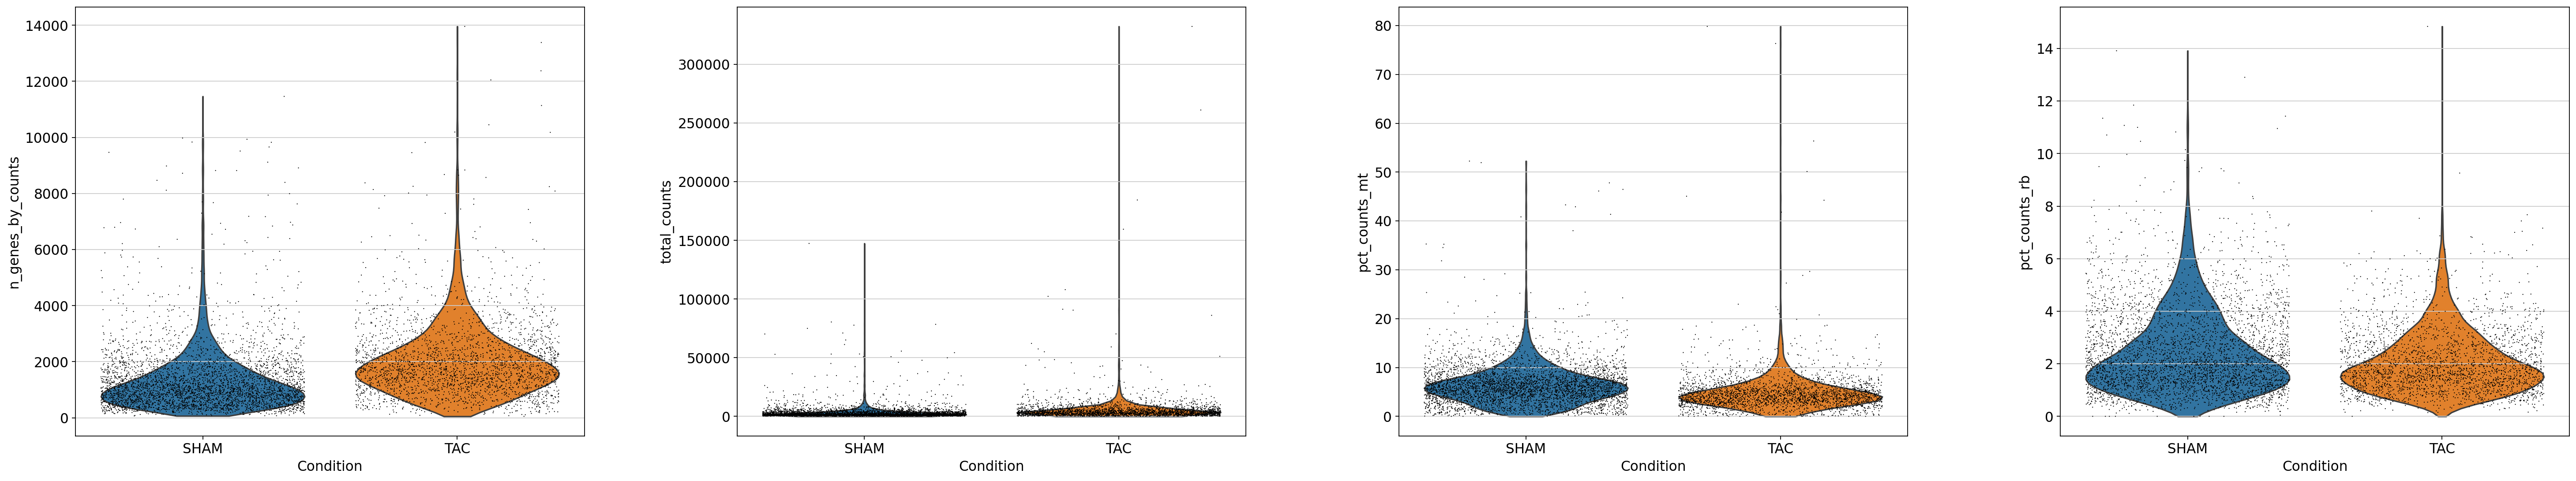

In [18]:
sc.pl.violin(Concatenato, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rb'],
             jitter=0.4, groupby = 'Condition')


In [19]:
print(Concatenato.n_obs, Concatenato.n_vars)
sc.pp.filter_cells(Concatenato, min_genes=200)
sc.pp.filter_genes(Concatenato, min_cells=3)
print(Concatenato.n_obs, Concatenato.n_vars)

6783 55336
6698 24362


In [20]:
# filter for percent mito
Concatenato = Concatenato[Concatenato.obs['pct_counts_mt'] < 20, :]

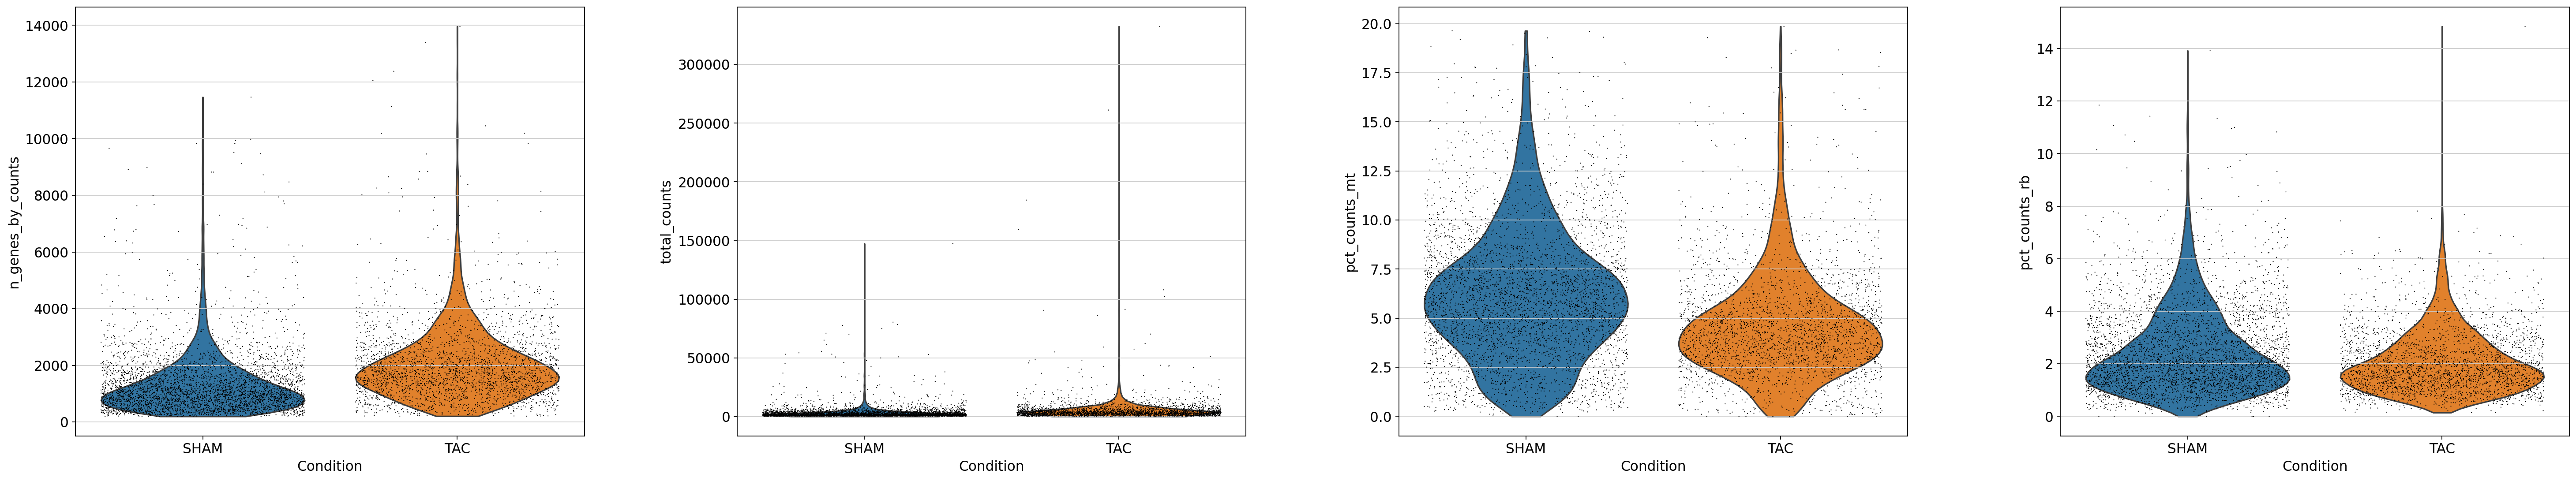

In [21]:
sc.pl.violin(Concatenato, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rb'],
             jitter=0.4, groupby = 'Condition')


In [22]:
keep_v3 = (Concatenato.obs['n_genes_by_counts'] < 6000) & (Concatenato.obs['n_genes_by_counts'] > 200) & (Concatenato.obs['total_counts'] < 10000)
print(sum(keep_v3))

# keep both sets of cells
keep = keep_v3
print(sum(keep))
Concatenato = Concatenato[keep, :]

print("Remaining cells %d"%Concatenato.n_obs)

6268
6268
Remaining cells 6268


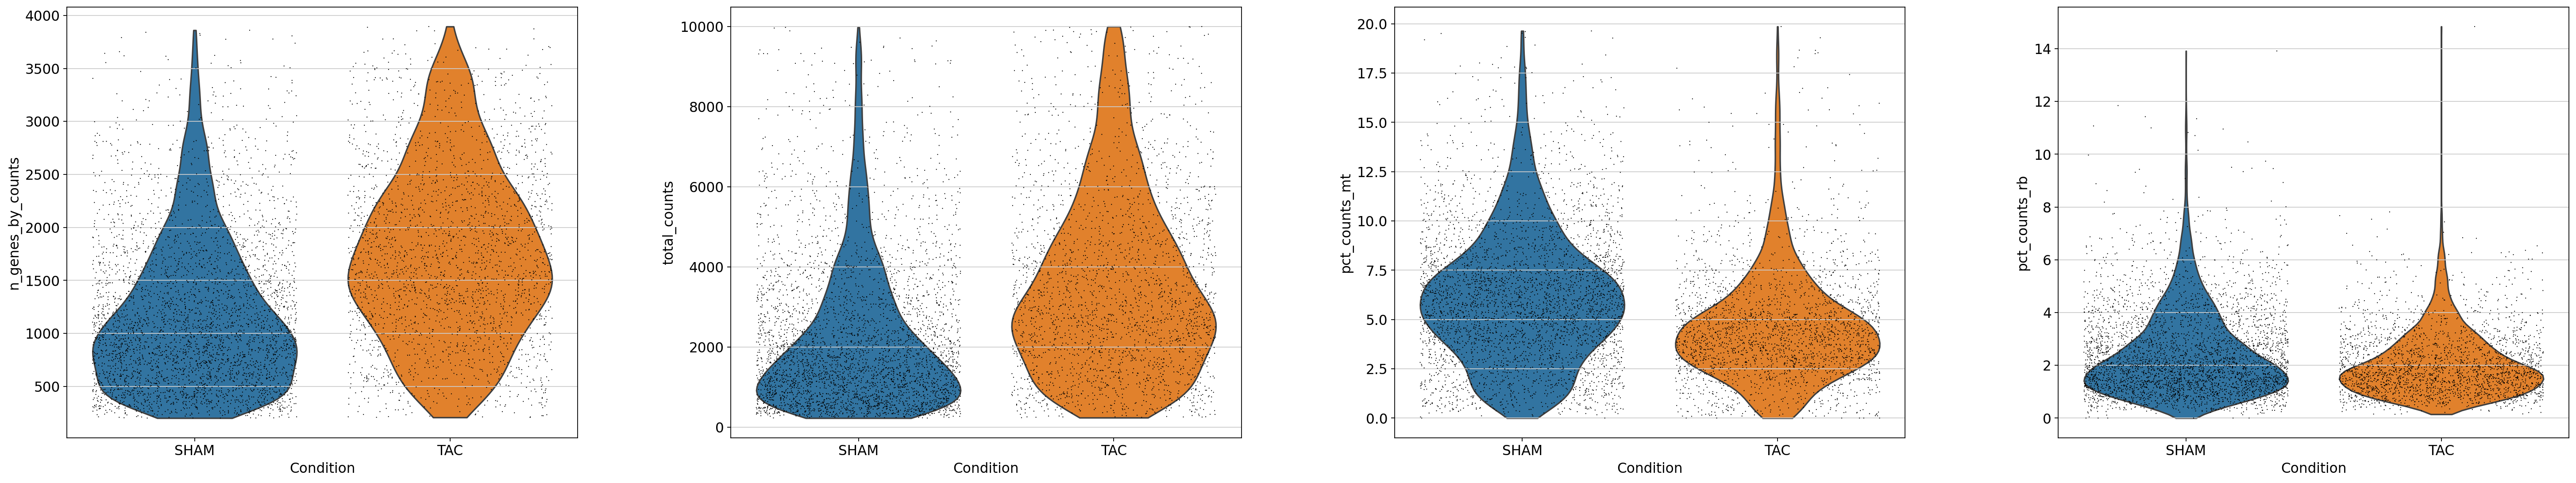

In [23]:
sc.pl.violin(Concatenato, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rb'],
             jitter=0.4, groupby = 'Condition')


In [24]:
Concatenato.obs.index = Concatenato.obs['OriginalBarcode'].astype(str)+"-"+Concatenato.obs['Condition'].astype(str)+"WT"

In [25]:
print(Concatenato.n_obs, Concatenato.n_vars)
malat1 = Concatenato.var_names.str.startswith('Malat1')
ribo_genes = Concatenato.var_names.str.startswith(("Rpl","Rps"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)
Concatenato = Concatenato[:,keep]
print(Concatenato.n_obs, Concatenato.n_vars)

6268 24362
6268 24153


In [26]:
print(Concatenato.n_obs, Concatenato.n_vars)
malat1 = Concatenato.var_names.str.startswith('Malat1')
mito_genes = Concatenato.var_names.str.startswith(("mt-"))
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)
Concatenato = Concatenato[:,keep]
print(Concatenato.n_obs, Concatenato.n_vars)

6268 24153
6268 24116


In [27]:
#import scprep

In [28]:
#Concatenato = Concatenato[(Concatenato[: , 'Cdh5'].X.A > 0) & (Concatenato[: , 'Pecam1'].X.A > 0), :]

In [29]:
#Concatenato = Concatenato[(Concatenato[: , 'Tomato'].X.A > 0), :]

In [30]:
Concatenato

View of AnnData object with n_obs × n_vars = 6268 × 24116
    obs: 'Condition', 'domain', 'OriginalBarcode', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rb', 'n_cells'
    uns: 'Condition_colors'

In [31]:
Concatenato_atac = sc.read("/home/lugli/spuccio/Projects/CNR002/TACSHAMWT.h5ad")

In [34]:
#Concatenato_atac.obs

In [42]:
Concatenato.obs.index = Concatenato.obs['OriginalBarcode'].astype(str)+"-"+Concatenato.obs['Condition'].astype(str)+"WT"

In [36]:
Concatenato = Concatenato[Concatenato.obs.index.isin(Concatenato_atac.obs.index)]


In [ ]:
Concatenato.obs.index = Concatenato.obs['OriginalBarcode'].astype(str)+"-"+Concatenato.obs['Condition'].astype(str)+"WT"

In [46]:
Concatenato_atac = Concatenato_atac[Concatenato_atac.obs.index.isin(Concatenato.obs.index)]


In [47]:
Concatenato.shape


(5443, 24116)

In [48]:
Concatenato_atac.shape

(5443, 5267565)

In [50]:
Concatenato.layers['counts'] = Concatenato.X

In [51]:
Concatenato.write("Concatenato_gex.h5ad")

In [52]:
Concatenato_atac.write("Concatenato_atax.h5ad")